Here we derive an analytic and Monte Carlo (MC) models of the fraction of the coincident microbursts observed by both spacecraft vs. one assuming a fixed scale size.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
import time
from IPython.display import Image
import pandas as pd

np.random.seed(123)
# plt.style.use('Solarize_Light2')

# Load and plot the CDF data

In [7]:
cdf_path = './../data/microburst_cdf_pdf_norm_v0.csv'
cdf_data = pd.read_csv(cdf_path)

In [8]:
cdf_data.head()

,Dist_Total,CDF,PDF
0,0.0,0.993496,0.064315
1,5.0,0.671922,0.051350
2,10.0,0.415173,0.008192
3,15.0,0.374212,0.006991
4,20.0,0.339258,0.005804


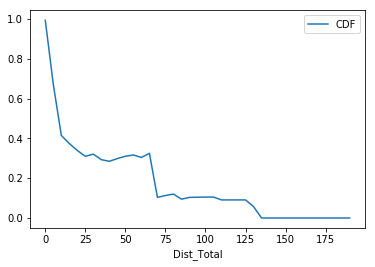

In [9]:
cdf_data.plot(x='Dist_Total', y='CDF');

# Develop a Monte Carlo model 
For development purposes we first assume a particular scale size distributon as a Gaussian with a mean value of s0 and width sigma_s

In [10]:
s0 = 10     
sigma_s = 20

Generate n_bursts number of microbursts with the s0 and sigma_s parameters above and randomy scatter them on a grid of hight/width grid_size.

In [11]:
s0 = 10
grid_size = 200
n_bursts = int(1E5)
burst_size = np.abs(np.random.normal(loc=s0, scale=sigma_s, size=n_bursts))
burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)

Visualize what the microbursts will look like on the grid.

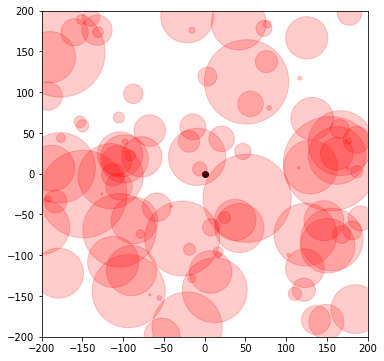

In [12]:
plot_n = 100
circles = plot_n*[None]
fig, ax = plt.subplots(figsize=(6, 6))

for c in range(plot_n):
    circles[c] = plt.Circle((burst_x[c], burst_y[c]), burst_size[c], color='r', alpha=0.2)
    ax.add_artist(circles[c])
plt.xlim(-grid_size, grid_size); plt.ylim(-grid_size, grid_size)
plt.scatter(0,0 , c='k')
ax.set_aspect(1.0)

Define a few helper functions to make the model look and run more smoothly

In [15]:
bins = cdf_data['Dist_Total']

def dist(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [16]:
def circle_intersect(line_p, circle_p):
    """ 
    Returns true if a cicle defined by circle_p argument 
    defined as [center_x, center_y, radius] intersects a
    line defined as [x1, y1, x2, y2]. The line is assume 
    to be finite in length. 
    
    Reference: http://mathworld.wolfram.com/Circle-LineIntersection.html
    """
    line_p[0] -= circle_p[0]; line_p[2] -= circle_p[0]
    line_p[1] -= circle_p[1]; line_p[3] -= circle_p[1]
    dx = line_p[2] - line_p[0]
    dy = line_p[3] - line_p[1]
    dr = np.sqrt(dx**2 + dy**2)
    D = line_p[0]*line_p[3] - line_p[2]*line_p[1]
    if circle_p[2]**(2)*dr**2 - D**2 >= 0:
        return True
    else:
        return False

Define the funcitons to tally the microburst events created above

In [17]:
def mc_model(dist_kwargs, dist=scipy.stats.poisson, bins=np.arange(100)):
    """ 
    Wrap the model to be optimized
    """
    n_bursts = int(1E5)
    burst_size = dist(*dist_kwargs, size=n_bursts)
    n_valid_bursts = len(np.where(burst_size > 0)[0])
    burst_size = burst_size[np.where(burst_size > 0)[0]]
    burst_x = np.random.uniform(-grid_size, grid_size, size=n_valid_bursts)
    burst_y = np.random.uniform(-grid_size, grid_size, size=n_valid_bursts)
    # Get the CDF
    cdf = cdf_tally_events(burst_x, burst_y, burst_size, bins)
    # Apply a log penatly (cost) function.
    #cost = -np.log(sum(np.power(cdf-cdf_data[:, 1], 2))/len(cdf))
    #cost = np.log(np.abs(sum(np.power(cdf-cdf_data[:, 1], 2))/len(cdf)))
#     if np.isnan(cost): 
#         cost = np.inf
    #cost -= x[2]
    #print('In model. x =', x, 'cost =', cost)
    return cdf#, cost
    
def cdf_tally_events(burst_x, burst_y, burst_size, bins):
    """ 
    This function tallies events that were see by both spacercaft over 
    the events seen by one, or both spacercaft as a function of spacecraft separation.
    """
    cdf = np.zeros(len(bins))    
    
    # Loop over the spacecraft separations.
    for i, d in enumerate(bins):
        n_single = 0
        n_both = 0
        # Loop over the microbursts.
        for bx, by, br in zip(burst_x, burst_y, burst_size):
            # Skip if the circle did not intersect the y-axis 
            # (not going to be seen by either spacecraft).
            if not circle_intersect([0, 0, 0, 10], [bx, by, br]):
                continue
            # Both see it
            if dist(bx, by, 0, d) <= br and dist(bx, by, 0, 0) <= br: 
                n_single += 1
                n_both += 1
            # Only the sc at distance d sees it.
            elif dist(bx, by, 0, d) <= br and dist(bx, by, 0, 0) > br:
                n_single +=1
            # Only the sc at the origin sees it.
            elif dist(bx, by, 0, d) > br and dist(bx, by, 0, 0) <= br:
                n_single +=1
        cdf[i] = n_both/n_single
    return cdf

In [18]:
mc_cdf = cdf_tally_events(burst_x, burst_y, burst_size, np.arange(100))
plt.plot(np.arange(100), mc_cdf);

KeyboardInterrupt: 

# Analytic Microburst Scale Size Model

Here is the geometric model of the problem. The diagram below shows two spacecraft as blue cubes, separated by some distance $d$. Then for a microburst of a given radius $r$, we can show the furthest distance at which a microburst of size $r$ will be observed by both spacecraft. This case is shown with two black circles to the left and right with respect to the line that connects the two spacecraft. The center of both black circles is marked with a black dot. 

Now we find the fraction of coincident microbursts to all microbursts observed by one and not the other spacecraft.

We first look at the number of coincident microbursts. Assume that we fire N microbursts into a world with an area $A_{world}$ (that is our canvas in the following diagram). The centers of microbursts that are coincidently observed must be at most a distance $r$ from both spacecraft. Geometrically we can visualize this by tracing the center of one of the black circles as we rotate it about one of the spacecraft location. The result of this rotation are the two red circles. The red shaded area in the middle, $A_1$ is the area in which if we place a microburst center, both spacercaft will see it.

To find the number of microbursts observed by one and not the other spacecraft, consider the same picture, but now the microburst center must lie outside of $A_1$. From our earlier circle rotation we traced out the solid red curve, which coincides with the furthest that a microburst center can be and be observed by one or the other spacecraft. Thus the area of this region is $2 \pi r^2 - A_1$. 

To put it all togeather, the fraction of coincident microbursts observed by two spacecraft is given by 

$$
F = \frac{A_1}{2 \pi r^2 - A_1}
$$. The Cumulative Distribution Fuction (CDF) is the derived by assuming a distribution of microbursts e.g. a Gaussian, and calculating $F$ as a function of $d$.

In [ ]:
Image("analytic_coincident_microburst_scale_size_bounds.png")

In [ ]:
A1 = lambda r, d: 2*r**2*np.arccos(d/(2*r)) - d/2*np.sqrt(4*r**2 - d**2)
# def A1(r, d):
    
#     if 4*r**2 - d**2 >= 0:
#         return 0
#     else:
#         return 2*r**2*np.arccos(d/(2*r)) - d/2*np.sqrt(4*r**2 - d**2)
F = lambda r, d: A1(r, d)/(2*np.pi*r**2 - A1(r, d))

Visualize the Analytical CDFs for a fixed-sized microburst

In [ ]:
d = np.arange(100)
r = np.arange(5, 25, 5)
plt.figure(figsize=(10, 6))

for r_i in r:
    plt.plot(d, F(r_i, d), label=r'$r_0 = $'+str(r_i));
plt.legend();
plt.xlabel('Spacecraft Sepration'); plt.ylabel('F');

# Validation of the MC vs Analytic models
Here I assume that all microbursts are the same size and check if the MC and the analytical models give the same result. I will then generalize the analytic model to make a CDF assuming some scale size PDF and not one value.

In [ ]:
def get_frac(r0, N=int(1E5), bins=np.arange(0, bins[-1])):
    """
    Validation function to get a fraction of microbursts observed
    as a function of spacecraft separation, assuming a fixed
    microburst scale size.
    """
    # Run the simulation
    burst_x = np.random.uniform(-grid_size, grid_size, size=N)
    burst_y = np.random.uniform(-grid_size, grid_size, size=N)
    r0 = r0*np.ones(N)
    # Tally the simulated events to make a cdf
    cdf = cdf_tally_events(burst_x, burst_y, r0, bins)
    return cdf

In [ ]:
start_time = time.time()
MCfrac = get_frac(20)
print('MC Run time {} s'.format(round(time.time()-start_time)))
start_time = time.time()
Afrac = F(20, np.arange(0, bins[-1]))
print('Analytic Run time {} s'.format(round(time.time()-start_time)))

In [ ]:
plt.plot(np.arange(bins[0], bins[-1]), MCfrac, 'r', label='MC'); 
plt.plot(np.arange(bins[0], bins[-1]), Afrac, 'b:', label='Analytic');
plt.legend();

# Generalize the Analytical Model to a Microburst PDF

In [ ]:
def analytic_model(dist_kwargs, dist=scipy.stats.poisson sc_bins=np.arange(100), microburst_scales=np.arange(200)):
    """
    Assuming a distribution for the microburst scale size, 
    calculate the microburst CDF at spacecraft separations 
    given by sc_bins kwarg. The contirbutions of 
    microbursts of sizes defined by the microburst_scales
    kwarg is considered here, and is superposed and weighted
    by their relative proibability of occuring as defined
    by the scale size Gaussian PDF.
    """
    # Assuming a distribution, calculate the probability of 
    # seeing a microburst of all sizes in microburst_scales.
    norm_cdf = dist(*dist_kwargs).cdf(microburst_scales)
    weights = norm_cdf[1:] - norm_cdf[:-1]
    weights /= sum(weights)
    # Apply the CDF weights to all microburst_scales
    CDF_arr = np.nan*np.zeros((len(microburst_scales), len(sc_bins)))
    for si, scale in enumerate(microburst_scales[:-1]):
        CDF_arr[si, :] = weights[si]*F(scale, sc_bins)
    return np.nansum(CDF_arr, axis=0)

In [ ]:
cdfMC = mc_model((10, 20))

In [ ]:
cdfA = analytic_model((10, 20))

In [ ]:
plt.plot(cdfA, 'r', label='Analytic'); plt.plot(cdfMC, label='MC'); plt.legend();